In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import imageio
import os
import shutil

# suppress warnings
import warnings
warnings.filterwarnings("ignore")


In [19]:
# Function to generate the time string based on date and time of day
def generate_time(date, time_of_day):
    # Convert date string to datetime object
    date_obj = datetime.strptime(date, '%Y%m%d')
    # Format the date part
    date_str = date_obj.strftime('%Y-%m-%d')
    # Combine date and time of day
    time_str = f'{date_str}T{time_of_day}'
    return time_str

def plot_rgb_image(ds, date, time_of_day, gif=False):
    """""
    Plot RGB image from xarray dataset and save as PNG.
    Parameters:
    ds (xarray.Dataset): The dataset containing the RGB channels.
    date (str): The date in 'YYYYMMDD' format.
    time_of_day (str): The time of day in 'HH:MM:SS' format.
    gif (bool): Whether to save the plot as a GIF.
    """

    # Extract the values as NumPy arrays
    red = ds['red'].values
    green = ds['green'].values
    blue = ds['blue'].values

    # Find the minimum shape among the arrays
    min_shape = np.min([red.shape, green.shape, blue.shape], axis=0)

    # Resize the arrays to the minimum shape
    red_resized = red[:min_shape[0], :min_shape[1]]
    green_resized = green[:min_shape[0], :min_shape[1]]
    blue_resized = blue[:min_shape[0], :min_shape[1]]

    # Ensure the arrays have the same dimensions
    assert red_resized.shape == green_resized.shape == blue_resized.shape, "Arrays must have the same shape"

    # Stack the arrays along the last dimension to create an RGB image
    rgb_image = np.stack([red_resized, green_resized, blue_resized], axis=-1)

    # Extract longitude and latitude values
    lon = ds['x'].values
    lat = ds['y'].values

    # Plot the RGB image using matplotlib's imshow
    rgb_plot = plt.imshow(rgb_image, extent=[lon.min(), lon.max(), lat.min(), lat.max()])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('GOES Day Cloud Phase RGB Composite - ' + date + ' ' + time_of_day + ' UTC')
    plt.axis('on')  # Show the axis

    # Save the plot as a PNG file
    filename = f'./plots/goes_RGB_{date}_{time_of_day}.png'
    plt.savefig(filename)

    
    if gif:
        plt.close()
        return filename
    else:
        return rgb_plot
        plt.show()

def zarr_to_rgb_image(ds, date, time_of_day):

    time = generate_time(date, time_of_day)

    # loop through the three channels
    for channel in ['02', '05', '13']:
        ds = open_zarr(date, channel, time)
        ds = normalize_to_255(ds)
        if channel == '02':
            ds_green = ds
        elif channel == '05':
            ds_blue = ds
        elif channel == '13':
            ds_red = ds

    return plot_rgb_image(ds, date, time_of_day)

def create_gif_from_pngs(png_dir, output_gif):
    # Get a list of all PNG files in the directory
    png_files = sorted([f for f in os.listdir(png_dir) if f.endswith('.png')])

    # Read each image and append it to the images list
    images = []
    for png_file in png_files:
        image_path = os.path.join(png_dir, png_file)
        images.append(imageio.imread(image_path))

    # Create and save the GIF
    imageio.mimsave(output_gif, images, duration=0.1)  # Adjust the duration as needed
    
def create_daily_goes_gif(date, start_time, end_time):
    start_time_out = start_time.replace(':', '')[:4]
    end_time_out =  end_time.replace(':', '')[:4]
    # Set the initial time and end time
    start_time = datetime.strptime(start_time, '%H:%M:%S')
    end_time = datetime.strptime(end_time, '%H:%M:%S')
    time_of_day = start_time

    # Path to the directory
    plots_dir = './plots'

    # Iterate over all files and directories in the specified directory
    for filename in os.listdir(plots_dir):
        file_path = os.path.join(plots_dir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)  # Remove the file or link
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # Remove the directory and its contents
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')

    # Loop through every 10 minutes
    while time_of_day <= end_time:
        time_of_day_str = time_of_day.strftime('%H:%M:%S')
        zarr_to_rgb_image(date, time_of_day_str)
        time_of_day += timedelta(minutes=10)
        print(f'Generated RGB image for {time_of_day_str}')

    # Directory containing PNG images
    png_dir = './plots'

    # Output GIF file path
    output_gif = f'./goes_RGB_{date}_{start_time_out}_{end_time_out}.gif'

    # Create the GIF
    create_gif_from_pngs(png_dir, output_gif)

    print(f"GIF saved as {output_gif}")

In [10]:
date = '20230603'
start_time = '12:00:00'
end_time = '23:50:00'

create_daily_goes_gif(date, start_time, end_time)

Generated RGB image for 12:00:00
Generated RGB image for 12:10:00
Generated RGB image for 12:20:00
Generated RGB image for 12:30:00
Generated RGB image for 12:40:00
Generated RGB image for 12:50:00
Generated RGB image for 13:00:00
Generated RGB image for 13:10:00
Generated RGB image for 13:20:00
Generated RGB image for 13:30:00
Generated RGB image for 13:40:00
Generated RGB image for 13:50:00
Generated RGB image for 14:00:00
Generated RGB image for 14:10:00
Generated RGB image for 14:20:00
Generated RGB image for 14:30:00
Generated RGB image for 14:40:00
Generated RGB image for 14:50:00
Generated RGB image for 15:00:00
Generated RGB image for 15:10:00
Generated RGB image for 15:20:00
Generated RGB image for 15:30:00
Generated RGB image for 15:40:00
Generated RGB image for 15:50:00
Generated RGB image for 16:00:00
Generated RGB image for 16:10:00
Generated RGB image for 16:20:00
Generated RGB image for 16:30:00
Generated RGB image for 16:40:00
Generated RGB image for 16:50:00
Generated 

In [4]:
from moviepy.editor import VideoFileClip

# Load the GIF
clip = VideoFileClip("/home/cdalden/goes_work/processing/goes_RGB_20230603_1200_2350.gif")

# Save as MP4
clip.write_videofile("goes_RGB_20230603_1200_2350.mp4", codec="libx264")

Moviepy - Building video goes_RGB_20230603_1200_2350.mp4.
Moviepy - Writing video goes_RGB_20230603_1200_2350.mp4



Moviepy - Done !
Moviepy - video ready goes_RGB_20230603_1200_2350.mp4


In [4]:
ds = xr.open_dataset('/storage/cdalden/goes/goes16/RGB_composite/goes16_C02_C05_C13_RGB_colorado_20230605.nc')
ds

<xarray.Dataset> Size: 9GB
Dimensions:    (t: 288, y: 640, x: 966)
Coordinates:
  * t          (t) datetime64[ns] 2kB 2023-06-05T00:02:36.606086016 ... 2023-...
    x_image    float32 4B ...
    y_image    float32 4B ...
  * y          (y) float64 5kB 41.53 41.52 41.51 41.51 ... 37.02 37.01 37.01
  * x          (x) float64 8kB -112.1 -112.1 -112.1 ... -104.0 -104.0 -104.0
Data variables:
    refl_C02   (t, y, x) float64 1GB ...
    refl_C05   (t, y, x) float64 1GB ...
    btemp_C13  (t, y, x) float64 1GB ...
    green      (t, y, x) float64 1GB ...
    blue       (t, y, x) float64 1GB ...
    red        (t, y, x) float64 1GB ...

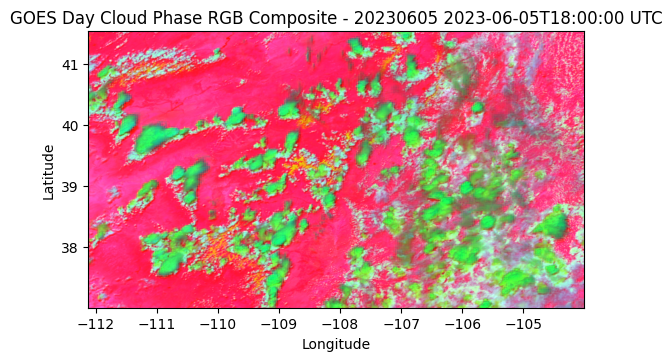

In [8]:
ds_i = ds.sel(t='2023-06-05T18:00:00', method='nearest')
plot_rgb_image(ds_i, '20230605', '2023-06-05T18:00:00')

In [20]:
# Define the start and end times
date = '20230605'
start_time = datetime.strptime('2023-06-05T16:00:00', '%Y-%m-%dT%H:%M:%S')
end_time = datetime.strptime('2023-06-05T23:00:00', '%Y-%m-%dT%H:%M:%S')

# List to store the filenames of the generated plots
filenames = []

# Loop through every 10-minute chunk
current_time = start_time
while current_time <= end_time:
    time_str = current_time.strftime('%Y-%m-%dT%H:%M:%S')
    ds_i = ds.sel(t=time_str, method='nearest')
    filename = plot_rgb_image(ds_i, '20230605', time_str, gif=True)
    filenames.append(filename)
    current_time += timedelta(minutes=10)
    print(f'Generated RGB image for {time_str}')

# Create the GIF
start_time_out = start_time.strftime('%H%M')
end_time_out =  end_time.strftime('%H%M')
output_gif = f'./goes_RGB_{date}_{start_time_out}_{end_time_out}.gif'
with imageio.get_writer(output_gif, mode='I', duration=0.5) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Clean up the temporary files
import os
for filename in filenames:
    os.remove(filename)

Generated RGB image for 2023-06-05T16:00:00
Generated RGB image for 2023-06-05T16:10:00
Generated RGB image for 2023-06-05T16:20:00
Generated RGB image for 2023-06-05T16:30:00
Generated RGB image for 2023-06-05T16:40:00
Generated RGB image for 2023-06-05T16:50:00
Generated RGB image for 2023-06-05T17:00:00
Generated RGB image for 2023-06-05T17:10:00
Generated RGB image for 2023-06-05T17:20:00
Generated RGB image for 2023-06-05T17:30:00
Generated RGB image for 2023-06-05T17:40:00
Generated RGB image for 2023-06-05T17:50:00
Generated RGB image for 2023-06-05T18:00:00
Generated RGB image for 2023-06-05T18:10:00
Generated RGB image for 2023-06-05T18:20:00
Generated RGB image for 2023-06-05T18:30:00
Generated RGB image for 2023-06-05T18:40:00
Generated RGB image for 2023-06-05T18:50:00
Generated RGB image for 2023-06-05T19:00:00
Generated RGB image for 2023-06-05T19:10:00
Generated RGB image for 2023-06-05T19:20:00
Generated RGB image for 2023-06-05T19:30:00
Generated RGB image for 2023-06-